# Stock price of Google

We will make an LSTM that will try to capture the downward and the upward
trend of the Google stock price because LSTM is the only powerful model that can do this as it performs way better than the traditional models. Apart from this, we are not going to perform a simple LSTM model. It's going to be super robust with some high-dimensionality, several layers as well as it is going to be a stacked LSTM, and then we will add some dropout regularization to avoid overfitting. Also, we will use the most powerful optimizer that we have in the Keras library.



In order to approach this problem, we will train our LSTM model on five years of the Google stock price, which is from the beginning of 2012 to the end of 2016 and then based on this training as well as on the identified correlations or captured by the LSTM of the Google stock price, we will try to predict the first month of 2017. We will try to predict January 2017, and again we are not going to predict exactly the stock price, but we are trying to predict the upward and downward trend of the Google stock price.

## Part1: Data Preprocessing

In [2]:
# Importing the libraries  
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

In [10]:
# Importing the training set  
dataset_train = pd.read_csv('/content/data/Google_Stock_Price_Train.csv')  
training_set = dataset_train.iloc[:, 1:2].values

In [11]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [12]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


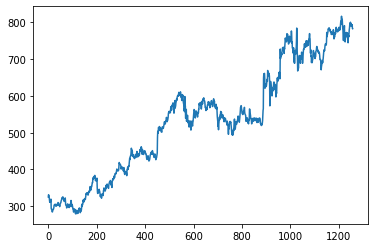

In [13]:
plt.plot(training_set)

After this, we will apply the feature scaling to our data to optimize the training process, and feature scaling can be done in two different ways, i.e., standardization and normalization.

So, this time is more relevant to use normalization because whenever we build an RNN and especially if there is a sigmoid function as the activation function in the output layer of the recurrent neural network, it is recommended to apply normalization.Here we have made feature_range equals to (0, 1) because if we look at the case of normalization, we will see that all the new scaled stock processes will be between 0 and 1, which is exactly what we want.

In [14]:
# Feature Scaling  
from sklearn.preprocessing import MinMaxScaler  
sc = MinMaxScaler(feature_range = (0, 1))  
training_set_scaled = sc.fit_transform(training_set)  

In the next step, we will create a specific data structure, which is the most important step of data preprocessing for Recurrent Neural Networks. Basically, we are going to create a data structure specifying what the RNN will need to remember when predicting the next stock price, which is actually called the number of timesteps and it is very important to have a right number of timesteps because the wrong number of timesteps could lead to overfitting or baseless predictions.

So, we will be creating 60 timesteps and 1 output, such that 60 timesteps mean that at each time T, the RNN is going to look back at 60 stock prices before time T, i.e., the stock prices between 60 days before time T and time T, and based on the trends, it is capturing during these 60 previous timesteps, it will try to predict the next output. So, 60 timesteps of the past information from which our RNN is going to learn and understand some correlations or some trends, and based on its understanding, it's going to try to predict the next output, i.e., the stock price at time t+1. Also, 60 timesteps refer to 60 previous financial days, and since there are 20 financial days in one month, so 60 timesteps correspond to three months, which means that each day we are going to look at the three previous months to try to predict the stock price the next day.

So, the first thing that we need to create two separate entities; the first entity that we will create is X_train, which will be the inputs of the neural network, and the second will be y_train that will contain the output. Basically, for each observation, or we can say for each financial day, X_train will contain 60 previous stock prices before that financial day, and y_train contain the stock price of the next financial day. We will start initializing these two separate entities, i.e., X_train and y_train, as an empty list.

In [15]:
# Creating a data structure with 60 timesteps and 1 output  
X_train = []  
y_train = []  
for i in range(60, 1258):  
    X_train.append(training_set_scaled[i-60:i, 0])  
    y_train.append(training_set_scaled[i, 0])  
X_train, y_train = np.array(X_train), np.array(y_train)  

print(X_train.shape,y_train.shape)

(1198, 60) (1198,)


In [16]:
X_train[:2]

array([[0.08581368, 0.09701243, 0.09433366, 0.09156187, 0.07984225,
        0.0643277 , 0.0585423 , 0.06568569, 0.06109085, 0.06639259,
        0.0614257 , 0.07474514, 0.02797827, 0.02379269, 0.02409033,
        0.0159238 , 0.01078949, 0.00967334, 0.01642607, 0.02100231,
        0.02280676, 0.02273235, 0.02810849, 0.03212665, 0.0433812 ,
        0.04475779, 0.04790163, 0.0440695 , 0.04648783, 0.04745517,
        0.04873875, 0.03936305, 0.04137213, 0.04034898, 0.04784582,
        0.04325099, 0.04356723, 0.04286033, 0.04602277, 0.05398467,
        0.05738894, 0.05714711, 0.05569611, 0.04421832, 0.04514845,
        0.04605997, 0.04412531, 0.03675869, 0.04486941, 0.05065481,
        0.05214302, 0.05612397, 0.05818885, 0.06540665, 0.06882953,
        0.07243843, 0.07993526, 0.07846566, 0.08034452, 0.08497656],
       [0.09701243, 0.09433366, 0.09156187, 0.07984225, 0.0643277 ,
        0.0585423 , 0.06568569, 0.06109085, 0.06639259, 0.0614257 ,
        0.07474514, 0.02797827, 0.02379269, 0.0

In [17]:
# Reshaping  
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  

print(X_train.shape)

(1198, 60, 1)


## Part 2 - Building the RNN
In the second part, we are going to build the whole architecture of the neural network, a robust architecture, because we are not only going to make a simple LSTM but a stacked LSTM with some dropout regularization to prevent overfitting.

So, we will import the Sequential class that will help us in creating the neural network object representing a sequence of layers, but also the Dense class to add the output layer. We will also import the LSTM class to add the LSTM layers and then the Dropout class to add some dropout regularization. This is all that we need to build a powerful RNN.

In [18]:
# Importing the Keras libraries and packages  
from keras.models import Sequential  
from keras.layers import Dense , BatchNormalization 
from keras.layers import LSTM  
from keras.layers import Dropout 
from keras import regularizers,optimizers

Next, we will initialize our Recurrent Neural Network as a sequence of layers as opposed to a computational graph. We will use the Sequential class from the Keras to introduce the regressor as a sequence of layers. Regressor is nothing but an object of the sequential class that represents the exact sequence of the layers.

In [19]:
# Initialising the RNN  
regressor = Sequential()  

# Adding the first LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))  
regressor.add(Dropout(0.2))  

# Adding a second LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50, return_sequences = True))  
regressor.add(Dropout(0.2))  

# Adding a third LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50, return_sequences = True))  
regressor.add(Dropout(0.2))  

# Adding a fourth LSTM layer and some Dropout regularization  
regressor.add(LSTM(units = 50))  
regressor.add(Dropout(0.2))  

# Adding the output layer  
regressor.add(Dense(units = 1))  

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

Let's compile the RNN with the right optimizer and the right loss function. So, we will start by taking our regressor as we are predicting a continuous value followed by using the compile method, which is another method of a sequential class, and inside the compile method, we will input two arguments, i.e., the optimizer and the loss function.

In general, for recurrent neural network, an RMS prop optimizer is recommended, but in our case of a problem, we will be using adam optimizer because it's always a safe choice as it very powerful and always perform some relevant updates of the weights. And the second argument that we will input is the loss function. Since we are not dealing with the classification problem, but the regression problem because we have to predict a continuous value, so this time the loss function is mean_squared_error due to the fact that the error can be measured by the mean of the squared differences between the predictions and targets, i.e., the real values.



In [31]:
# Compiling the RNN  
regressor.compile(optimizer = optimizers.Adam(lr=1e-5), loss = 'mean_absolute_error')  

# Fitting the RNN to the Training set  
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=1)  

Epoch 1/100
38/38 [==============================] - 5s 15ms/step - loss: 0.0218
Epoch 2/100
38/38 [==============================] - 0s 11ms/step - loss: 0.0216
Epoch 3/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0218
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 0.0217
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0213
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 0.0228
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0207
Epoch 8/100
38/38 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 9/100
38/38 [==============================] - 0s 11ms/step - loss: 0.0200
Epoch 10/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 11/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0220
Epoch 12/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0207
Epoch 13/100
38/38 [=====

## Part 3 - Making the predictions and visualizing the results
First, we will get the real stock price of 2017, then in the second step, we will get the predicted stock price of 2017, and lastly, we will visualize the results. So, in order to get the real stock price of 2017, we will get it from the test set in the CSV file, and therefore we will just do exactly the same as what we did for our training set.

We will simply start with creating a data frame by importing the Google_Stock_Price_Test.csv file with the read_csv function by pandas, and then we will select the right column, the open google stock price followed by making it a NumPy array that we will do by replacing the training set by the test set. Since the test set is going to be the real values of the Google stock price in the first month of
January 2017, so we will simply replace the training_set by the real_stock_price.

In [22]:
# Getting the real stock price of 2017  
dataset_test = pd.read_csv('data/Google_Stock_Price_Test.csv')  
real_stock_price = dataset_test.iloc[:, 1:2].values  

In [29]:
# Getting the predicted stock price of 2017  
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) 

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values  
print(dataset_total.shape)

(1278,)


In [25]:
inputs = inputs.reshape(-1,1)  
inputs = sc.transform(inputs)  

In [26]:
X_test = []  
for i in range(60, 80):  
    X_test.append(inputs[i-60:i, 0])  
X_test = np.array(X_test)  
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  

In [32]:
predicted_stock_price = regressor.predict(X_test)  
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  

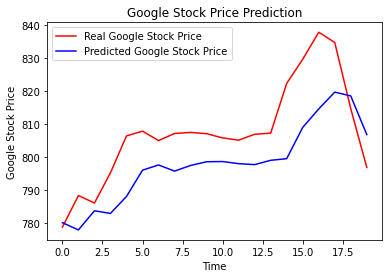

In [33]:
# Visualizing the results  
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')  
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')  
plt.title('Google Stock Price Prediction')  
plt.xlabel('Time')  
plt.ylabel('Google Stock Price')  
plt.legend()  
plt.show()  

From the above input, we can see that we have the real Google stock price in red and our predicted Google stock price in blue. We also get a comparison of the real and the predicted Google stock prices for the whole month of January 2017. We have got the real Google stock price from the verified financial sources from the web. However, the predictions are coming from the RNN model that we just implemented.

We can see in some parts our predictions are lagging behind the actual values. We can clearly see a big spike, like a stock time singularity, which is not followed by the predictions, and it is completely normal. Out model just lags behind because it cannot react to fast, nonlinear changes.